# Importing libraries

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import logging
from sklearn.metrics import f1_score  

cudnn.benchmark = True
plt.ion()   # interactive mode

# Utils

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# def imshow(inp, title=None):
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, device, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, phase_names, device, log):
  try:
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch + 1}/{num_epochs}')
      print('-' * 10)
      if log is not None:
        log.info(f'Epoch {epoch + 1}/{num_epochs}')

      # Each epoch has a training and validation phase
      for phase in phase_names:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        # running_f1

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
          # running_f1 = f1_score(labels.data, preds)
        if phase == 'train':
          scheduler.step()
          
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        # epoch_f1 = running_f1.double() / dataset_sizes[phase]

        print(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')
        if log is not None:
          log.info(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val acc: {best_acc:4f}')
    if log is not None:
      log.info(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      log.info(f'Best val acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
  except KeyboardInterrupt:
    print('Function interrupted')
    if log is not None:
      log.info('Function interrupted\n\n\n')
    return None

In [ ]:
def define_dataloaders(dataset_name, batch_size=32, val=False):
  data_dir = '/content'
  train = dataset_name + '_train'
  test = dataset_name + '_test'
  phase_names = ['train', 'test']
  phase_folders = [train, test]
  if val:
    VAL = dataset_name + '_val'
    phase_names.append('val')
    phase_folders.append(VAL)

  data_transforms = {
      'train': transforms.Compose([
          transforms.Resize(224),
          transforms.ToTensor(),
      ]),
      'test': transforms.Compose([
          transforms.Resize(224),
          transforms.ToTensor(),
      ]),
  }

  image_datasets = {pn: datasets.ImageFolder(os.path.join(data_dir, pf),
                                            data_transforms[pn])
                    for pn, pf in zip(phase_names, phase_folders)}
  dataloaders = {pn: torch.utils.data.DataLoader(image_datasets[pn], 
                                                batch_size=batch_size,
                                                shuffle=True, num_workers=2) 
                for pn in phase_names}
  dataset_sizes = {pn: len(image_datasets[pn]) for pn in phase_names}
  class_names = image_datasets['train'].classes

  for pn in phase_names:
      print("Loaded {} images under {}".format(dataset_sizes[pn], pn))
      
  class_names = image_datasets['train'].classes
  print('Classes: %s' % image_datasets['train'].classes)
  return dataloaders, dataset_sizes, class_names

In [ ]:
def check_gpu(log=None):
  if torch.cuda.is_available():
    print('GPU is available. Running on GPU')
    # if log is not None:
    #   log.info('GPU is available. Running on GPU')
    device = "cuda:0"
  else:
    print('GPU is NOT available. Running on CPU')
    # if log is not None:
    #   log.info('GPU is NOT available. Running on CPU')
    device = "cpu"
  return device

# Connect to Google Drive (if needed)

In [ ]:
# Подключить к google colab содержимое вашего google диск
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define logs

In [ ]:
def define_logs(logs_folder, logs_filename):
  if not os.path.isdir(logs_folder):
    os.mkdir(logs_folder)
  logs_path = os.path.join(logs_folder, logs_filename)
  log_formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
  logger = logging.getLogger('experimental_classification')
  logger.setLevel(logging.DEBUG)
  file_handler = logging.FileHandler(logs_path)
  file_handler.setLevel(logging.DEBUG)
  file_handler.setFormatter(log_formatter)
  logger.addHandler(file_handler)
  print('Logger was initialized successfully')
  return logger

In [ ]:
logs_folder = "/content/drive/MyDrive/Master/MW/logs"
logs_filename = "SWaT_Dec2019_classify_experimental_images_with_transfer_learning.log"
logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)

Logger was initialized successfully


# Downloading data

In [ ]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train.tar.gz"
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/SWaT/SWaT_2019/images/SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_test.tar.gz"

Выходные данные были обрезаны до нескольких последних строк (5000).
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601252.100557_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601281.652342_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601480.321462_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601252.601782_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601358.66996_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601246.632496_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601362.73296_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601371.16276_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation_train/attack/1575601232.287795_1.jpg
SWaT_Dec2019_agg_p_ts_experimental_

# Define dataloaders and constants

In [ ]:
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
device = check_gpu(log=logger)
dataset_name = 'SWaT_Dec2019_agg_p_ts_experimental_image_linear_transformation'
LEARNING_RATE = 0.005
STEP_SIZE = 2
GAMMA = 0.1
EPOCHS_COUNT = 7
BATCH_SIZE = 32
VALIDATION = False

dataloaders, dataset_sizes, class_names = define_dataloaders(dataset_name=dataset_name, batch_size=BATCH_SIZE, val=VALIDATION)
if VALIDATION:
  phase_names = ['train', 'test', 'val']
else:
  phase_names = ['train', 'test']

GPU is available. Running on GPU
Loaded 14705 images under train
Loaded 7856 images under test
Classes: ['attack', 'normal']


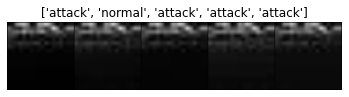

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

# ResNet34

## One head layer

In [ ]:
model_resnet34 = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34.fc.in_features
model_resnet34.fc = nn.Linear(num_features_resnet34, len(class_names))
model_resnet34.name = 'ResNet34'
model_resnet34 = model_resnet34.to(device)

criterion_resnet34 = nn.CrossEntropyLoss()
optimizer_resnet34 = optim.SGD(model_resnet34.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34 = lr_scheduler.StepLR(optimizer_resnet34, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34.name)
model_resnet34 = train_model(model=model_resnet34, 
                             criterion=criterion_resnet34, 
                             optimizer=optimizer_resnet34,
                             scheduler=exp_lr_scheduler_resnet34, 
                             num_epochs=EPOCHS_COUNT, 
                             dataloaders=dataloaders, 
                             phase_names=phase_names,
                             device=device,
                             log=logger)
if model_resnet34 is not None: 
  print('Train %s model end' % model_resnet34.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34.name)

Epoch 1/7
----------
train loss: 0.7818 acc: 0.6182
test loss: 0.6232 acc: 0.6853

Epoch 2/7
----------
train loss: 0.6621 acc: 0.6672
test loss: 0.7517 acc: 0.5829

Epoch 3/7
----------
train loss: 0.6191 acc: 0.6852
test loss: 0.6700 acc: 0.6245

Epoch 4/7
----------
train loss: 0.5984 acc: 0.6943
test loss: 0.5992 acc: 0.7000

Epoch 5/7
----------
train loss: 0.5692 acc: 0.7129
test loss: 0.5862 acc: 0.7011

Epoch 6/7
----------
train loss: 0.5720 acc: 0.7069
test loss: 0.6437 acc: 0.6472

Epoch 7/7
----------
train loss: 0.5537 acc: 0.7207
test loss: 0.5833 acc: 0.6886

Training complete in 6m 22s
Best val acc: 0.701114
CPU times: user 5min 44s, sys: 20.8 s, total: 6min 5s
Wall time: 6min 22s


## Multiple head layers

In [ ]:
model_resnet34_head = torchvision.models.resnet34(pretrained=True)
for param in model_resnet34_head.parameters():
    param.requires_grad = False
num_features_resnet34 = model_resnet34_head.fc.in_features
head_model = nn.Sequential(
	nn.Linear(num_features_resnet34, 512),
	nn.ReLU(),
	nn.Dropout(0.1),
	nn.Linear(512, 256),
	nn.ReLU(),
	nn.Dropout(0.05),
	nn.Linear(256, len(class_names))
)
model_resnet34_head.fc = head_model
model_resnet34_head.name = 'ResNet34withHead'
model_resnet34_head = model_resnet34_head.to(device)

criterion_resnet34_head = nn.CrossEntropyLoss()
optimizer_resnet34_head = optim.SGD(model_resnet34_head.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
exp_lr_scheduler_resnet34_head = lr_scheduler.StepLR(optimizer_resnet34_head, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
%%time
# logger = define_logs(logs_folder=logs_folder, logs_filename=logs_filename)
print('Device: %s' % device)
print('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
print('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34_head.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
print('Train %s model start ...' % model_resnet34_head.name)
if logger is not None:
  logger.info('Device: %s' % device)
  logger.info('Data: %s, batch size: %s' % (dataset_name, BATCH_SIZE))
  logger.info('%s model parameters: LR: %s, SS: %s, G: %s, EC: %s' % (model_resnet34_head.name, LEARNING_RATE, STEP_SIZE, GAMMA, EPOCHS_COUNT))
  logger.info('Train %s model start ...' % model_resnet34_head.name)
model_resnet34_head = train_model(model=model_resnet34_head, 
                                  criterion=criterion_resnet34_head, 
                                  optimizer=optimizer_resnet34_head,
                                  scheduler=exp_lr_scheduler_resnet34_head, 
                                  num_epochs=EPOCHS_COUNT, 
                                  dataloaders=dataloaders, 
                                  phase_names=phase_names,
                                  device=device,
                                  log=logger)
if model_resnet34_head is not None: 
  print('Train %s model end' % model_resnet34_head.name)
  if logger is not None: 
    logger.info('Train %s model end\n\n\n' % model_resnet34_head.name)

# MobileNet_v3_small